In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
import cv2
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.svm import SVC
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report

In [2]:
seed = 45

In [3]:
data_category = pd.read_csv('info_category.csv', delimiter=';', decimal=".") 
print(data_category.shape)

(493, 4)


In [4]:
def prepare_data(file_name, data_category):
    data = pd.read_csv(file_name+'.csv', delimiter=';', decimal=".") 
    data = data_category.merge(data, left_on=['img_name','folder','image'], right_on=['img_name','folder','image'])
    data[['category']] =  data[['category']].abs()
    data = data[data.category>0]
    data[['category']] =  data[['category']]-1
    return data

In [5]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV

file_name = 'info_h_40'
sections_width = int(file_name.split("_")[-1])
data = prepare_data(file_name, data_category)
size_m = sections_width
X_values = data[['h_'+str(a) for a in range(1,size_m+1)]]
y_values = data[['category']]
X_train, X_test, y_train, y_test = train_test_split(X_values, y_values, test_size=0.2, random_state=seed)

#parameters = {'n_neighbors':range(3,7), 'p':[1,2,4]}
parameters = {'C':range(1,10), 'class_weight':['balanced', None]}
svc = SVC(random_state=seed)#KNeighborsClassifier()
clf = GridSearchCV(svc, parameters, scoring='precision_weighted', cv=6)
clf.fit(X_values, y_values.values.ravel())

data = pd.DataFrame(clf.cv_results_)
data.sort_values(by=['rank_test_score'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
8,0.002992,8.885336e-08,0.001662,4.701060e-04,5,balanced,"{'C': 5, 'class_weight': 'balanced'}",0.767783,0.754031,0.894444,0.950751,0.839972,0.784910,0.831982,0.071280,1
10,0.003158,3.717980e-04,0.001662,4.699374e-04,6,balanced,"{'C': 6, 'class_weight': 'balanced'}",0.767783,0.754031,0.894444,0.950751,0.839972,0.784910,0.831982,0.071280,1
7,0.002826,3.722314e-04,0.001495,4.997295e-04,4,None,"{'C': 4, 'class_weight': None}",0.747368,0.791667,0.894444,0.974775,0.839972,0.739865,0.831348,0.083290,3
3,0.002825,3.716736e-04,0.001995,1.820952e-07,2,None,"{'C': 2, 'class_weight': None}",0.767783,0.754031,0.894444,0.974775,0.839972,0.739865,0.828478,0.084622,4
5,0.002992,5.757254e-04,0.001164,3.718691e-04,3,None,"{'C': 3, 'class_weight': None}",0.767783,0.754031,0.894444,0.974775,0.839972,0.739865,0.828478,0.084622,4
17,0.002825,3.716381e-04,0.001663,4.701060e-04,9,None,"{'C': 9, 'class_weight': None}",0.747368,0.777906,0.853743,0.950751,0.800164,0.823710,0.825607,0.065192,6
6,0.003158,3.717803e-04,0.001662,4.699936e-04,4,balanced,"{'C': 4, 'class_weight': 'balanced'}",0.767783,0.754031,0.894444,0.950751,0.800164,0.784910,0.825347,0.072076,7
9,0.002826,3.718513e-04,0.001995,2.139872e-07,5,None,"{'C': 5, 'class_weight': None}",0.747368,0.739035,0.894444,0.974775,0.800164,0.784910,0.823449,0.084539,8
4,0.003324,4.702746e-04,0.001330,4.700498e-04,3,balanced,"{'C': 3, 'class_weight': 'balanced'}",0.767783,0.754031,0.894444,0.950751,0.786593,0.784910,0.823085,0.073037,9
16,0.003158,3.716381e-04,0.001995,2.247832e-07,9,balanced,"{'C': 9, 'class_weight': 'balanced'}",0.769866,0.777906,0.853743,0.950751,0.800164,0.784910,0.822890,0.063370,10


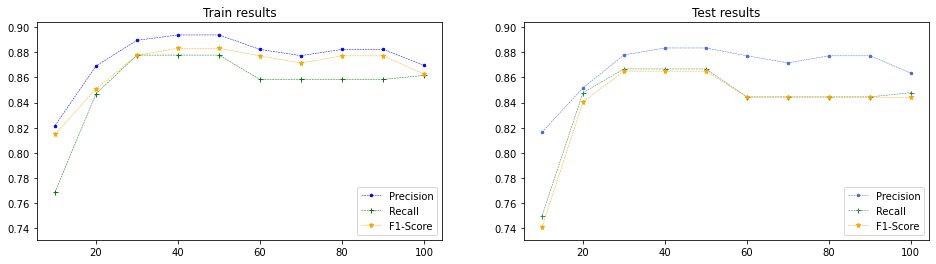

,width,data,precision_train,recall_train,f1_score_train,precision_test,recall_test,f1_score_test
0,40,225,0.893668,0.877672,0.883116,0.883333,0.866667,0.864956
0,50,225,0.893668,0.877672,0.883116,0.883333,0.866667,0.864956
0,30,225,0.889435,0.877672,0.877443,0.877778,0.866667,0.864956
0,60,224,0.882163,0.858312,0.877065,0.877095,0.844444,0.844316
0,80,224,0.882163,0.858312,0.877065,0.877095,0.844444,0.844316
0,90,224,0.882163,0.858312,0.877065,0.877095,0.844444,0.844316
0,70,224,0.877237,0.858312,0.871386,0.871508,0.844444,0.844316
0,100,229,0.869668,0.861542,0.862705,0.863388,0.847826,0.844075
0,20,228,0.869025,0.847016,0.850926,0.851648,0.847826,0.840510
0,10,259,0.821638,0.768853,0.814678,0.816425,0.750000,0.740967


In [6]:
widths = [10,20,30,40,50,60,70,80,90,100]
final_data = pd.DataFrame()
for w in range(0,len(widths)):
    info_results = []    
    file_name = 'info_h_'+str(widths[w])
    sections_width = int(file_name.split("_")[-1])
    data = prepare_data(file_name, data_category)    
    size_m = sections_width
    columns = ['h_'+str(a) for a in range(1,size_m+1)] #+ ['pw_'+str(a) for a in range(1,size_m+1)]
    X_values = data[columns]
    y_values = data[['category']]
    X_train, X_test, y_train, y_test = train_test_split(X_values, y_values, test_size=0.2, random_state=seed)
    kmeans = SVC(C=5, class_weight='balanced', random_state=seed) #KNeighborsClassifier(n_neighbors=6, p=4) #GaussianNB() # 
    kmeans.fit(X_train, y_train.values.ravel())
    y_predict = kmeans.predict(X_train)
    precision_train = (precision_score(y_train, y_predict, average='weighted'))
    recall_train= (recall_score(y_train, y_predict, average='weighted'))
    f1_score_train = f1_score(y_train, y_predict, average='weighted')
    y_predict = kmeans.predict(X_test)
    precision_test = (precision_score(y_test, y_predict, average='weighted'))
    recall_test = (recall_score(y_test, y_predict, average='weighted'))
    f1_score_test = f1_score(y_test, y_predict, average='weighted')
    data_row= [ widths[w], data.shape[0],precision_train, recall_train,precision_test,recall_test, f1_score_train, f1_score_test]
    info_results.append(data_row)
    info_results =pd.DataFrame(info_results, columns=['width','data','precision_train', 'precision_test', 'recall_train', 'recall_test', 'f1_score_train', 'f1_score_test']) 
    final_data = pd.concat([final_data, info_results])

max_value = final_data[['precision_train', 'recall_train', 'f1_score_train', 'precision_test', 'recall_test', 'f1_score_test']].values.max() + 0.01
min_value = final_data[['precision_train', 'recall_train', 'f1_score_train', 'precision_test', 'recall_test', 'f1_score_test']].values.min() - 0.01

fig, axs = plt.subplots(1,2, figsize=(16,4))
axs[0].title.set_text("Train results")
axs[0].plot(final_data.width,final_data.precision_train,marker='.',linestyle='dashed', color='blue',linewidth=0.5,markersize=5, label='Precision')
axs[0].plot(final_data.width,final_data.recall_train,marker='+',linestyle='dashed',color='green',linewidth=0.5,markersize=5, label='Recall')
axs[0].plot(final_data.width,final_data.f1_score_train,marker='*',linestyle='dashed',color='orange',linewidth=0.5,markersize=5, label='F1-Score')
axs[0].legend()
axs[0].set_ylim([min_value, max_value])

axs[1].title.set_text("Test results")
axs[1].plot(final_data.width,final_data.precision_test,marker='.',linestyle='dashed', color='royalblue',linewidth=0.5,markersize=5, label='Precision')
axs[1].plot(final_data.width,final_data.recall_test,marker='+',linestyle='dashed',color='seagreen',linewidth=0.5,markersize=5, label='Recall')
axs[1].plot(final_data.width,final_data.f1_score_test,marker='*',linestyle='dashed',color='orange',linewidth=0.5,markersize=5, label='F1-Score')
axs[1].legend()
axs[1].set_ylim([min_value, max_value])

plt.show()

final_data = final_data.reindex(['width', 'data','precision_train', 'recall_train', 'f1_score_train', 'precision_test', 'recall_test', 'f1_score_test'], axis=1)
final_data.sort_values(by=['f1_score_train','f1_score_test'], ascending=False)

(225, 84)


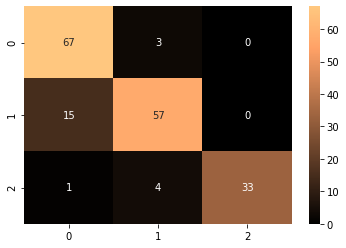

              precision    recall  f1-score   support

           k       0.81      0.96      0.88        70
           s       0.89      0.79      0.84        72
           b       1.00      0.87      0.93        38

    accuracy                           0.87       180
   macro avg       0.90      0.87      0.88       180
weighted avg       0.88      0.87      0.87       180



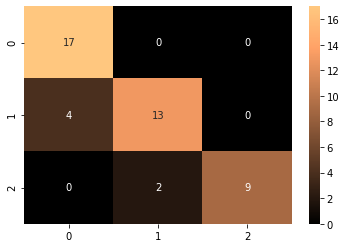

              precision    recall  f1-score   support

           k       0.81      1.00      0.89        17
           s       0.87      0.76      0.81        17
           b       1.00      0.82      0.90        11

    accuracy                           0.87        45
   macro avg       0.89      0.86      0.87        45
weighted avg       0.88      0.87      0.86        45



In [7]:
from sklearn.preprocessing import normalize
file_name = 'info_h_40'
sections_width = int(file_name.split("_")[-1])
data = prepare_data(file_name, data_category)
size_m = sections_width
columns = ['h_'+str(a) for a in range(1,size_m+1)] #+ ['pw_'+str(a) for a in range(1,size_m+1)]
X_values = data[columns]
y_values = data[['category']]
print(data.shape)
X_train, X_test, y_train, y_test = train_test_split(X_values, y_values, test_size=0.2, random_state=seed)
kmeans = SVC(C=3, class_weight='balanced', random_state=seed)#KNeighborsClassifier(n_neighbors=3)#SVC(C=5, class_weight='balanced')#
kmeans.fit(X_train, y_train.values.ravel())
y_predict_train = kmeans.predict(X_train)
precision_train = (precision_score(y_train, y_predict_train, average='weighted'))
recall_train= (recall_score(y_train, y_predict_train, average='weighted'))
y_predict = kmeans.predict(X_test)
precision_test = (precision_score(y_test, y_predict, average='weighted'))
recall_test = (recall_score(y_test, y_predict, average='weighted'))
data_row= [ precision_train, recall_train,precision_test,recall_test]
conf_matrix = confusion_matrix(y_train.values.ravel(),y_predict_train)
sns.heatmap(conf_matrix, annot=True,fmt='d', cmap=plt.cm.copper)
plt.show()
print(classification_report(y_train.values.ravel(),y_predict_train, target_names=['k', 's', 'b']))
conf_matrix = confusion_matrix(y_test.values.ravel(),y_predict)
sns.heatmap(conf_matrix, annot=True,fmt='d', cmap=plt.cm.copper)
plt.show()
print(classification_report(y_test.values.ravel(),y_predict, target_names=['k', 's', 'b']))